# Preprocess Data

In [1]:
import numpy as np
import pandas as pd

def read_data_from_UCI():
    """Reads the bank-marketing data table from a zip file directly from UCI"""
    import zipfile
    import io
    from urllib import request

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    with request.urlopen(url) as r:
        with zipfile.ZipFile(io.BytesIO(r.read())) as zf:
            csv_file = zf.open("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(csv_file, sep=";")
    return df

In [2]:
data = read_data_from_UCI()
data.shape

(41188, 21)

In [3]:
print(data['y'].unique())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(data['y']))
y.mean()

['no' 'yes']


0.11265417111780131

In [4]:
print(data['contact'].unique())
a = pd.Series(le.fit_transform(data['contact']))
a.mean()

['telephone' 'cellular']


0.3652520151500437

In [5]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
               'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [6]:
confounders += ['month', 'campaign']

In [7]:
X = data[confounders]
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
month              object
campaign            int64
dtype: object

In [8]:
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)
X.head()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign,job=blue-collar,...,poutcome=success,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,37,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,40,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0


# IPW Estimate (Initial)

In [9]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)

In [10]:
ipw.fit(X, a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [11]:
propMatrix = ipw.compute_propensity_matrix(X, a)

In [12]:
# save data
# X.to_json("../public/cohort_confounds.json", orient="records")
# y.to_json("../public/cohort_outcome.json", orient="records")
# a.to_json("../public/cohort_treatment.json", orient="records")
# propMatrix.to_json("../public/cohort_propensity.json", orient="records")
# weights = np.ones_like(propMatrix[1])/float(len(propMatrix[1]))

In [13]:
import matplotlib.pyplot as plt

In [14]:
outcomes = ipw.estimate_population_outcome(X, a, y)
outcomes

0    0.155379
1    0.223001
dtype: float64

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:451: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(1 - fold_predictions.propensity)
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [pd.Series(data=targets.max(), index=fold_predictions.propensity.index).append(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:465: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(fold_predictions.propensity)


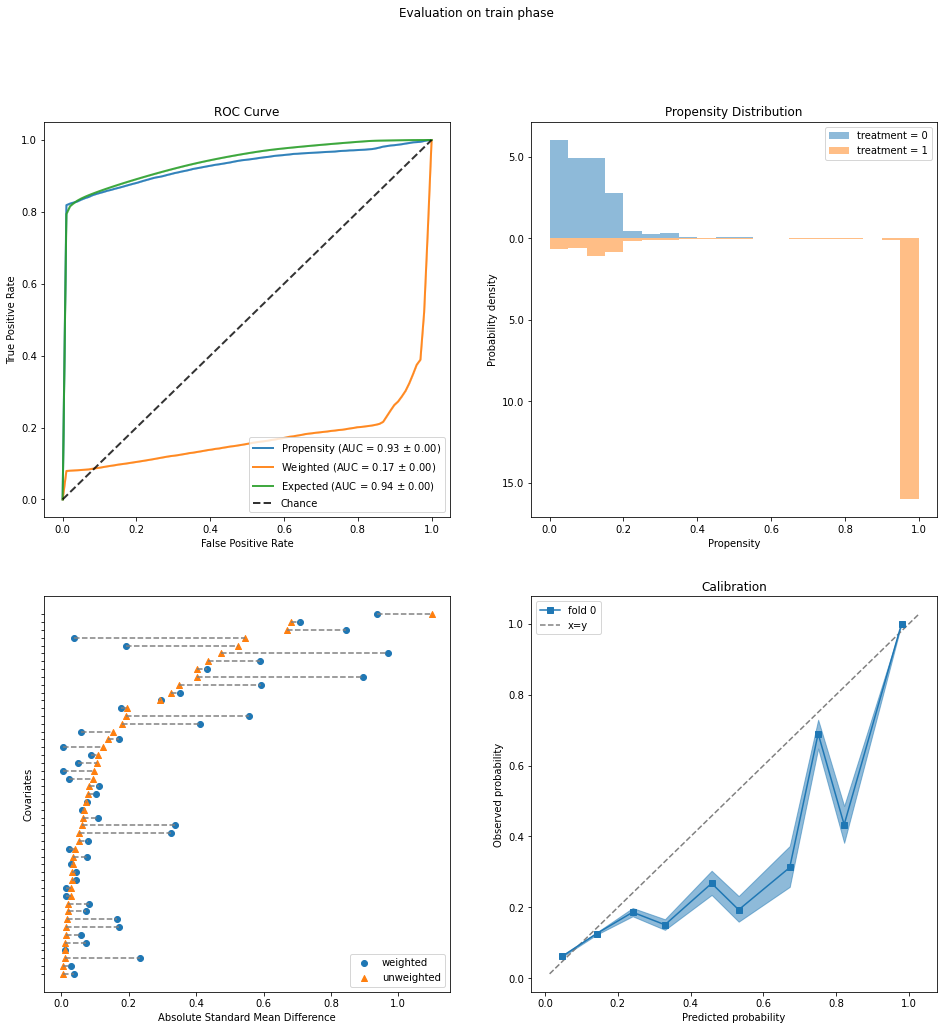

In [15]:
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X, a, y, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])
# evaluator.evaluate_simple(X, a, y, plots=["covariate_balance_love"])

# Cohort Refinement

In [20]:
# indExclude = (X['cons.price.idx'] > 93.92) & (X['euribor3m'] > 4.5)
indExclude = (X['euribor3m'] > 4.5)
a[indExclude].mean()

0.5546560385270063

In [21]:
y2 = y.loc[~indExclude]
a2 = a.loc[~indExclude]
X2 = X.loc[~indExclude]
print(y.mean())
print(a.mean())

0.11265417111780131
0.3652520151500437


In [22]:
ipw.fit(X2, a2)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

In [27]:
propMatrix2 = ipw.compute_propensity_matrix(X2, a2)
len(X2)

17101

In [29]:
# X2.to_json("../public/cohort2_confounds.json", orient="records")
# propMatrix2.to_json("../public/cohort2_propensity.json", orient="records")
# a2.to_json("../public/cohort2_treatment.json", orient="records")
# y2.to_json("../public/cohort2_outcome.json", orient="records")

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:451: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(1 - fold_predictions.propensity)
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [pd.Series(data=targets.max(), index=fold_predictions.propensity.index).append(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/causallib/evaluation/weight_evaluator.py:465: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  "expected": [fold_predictions.propensity.append(fold_predictions.propensity)


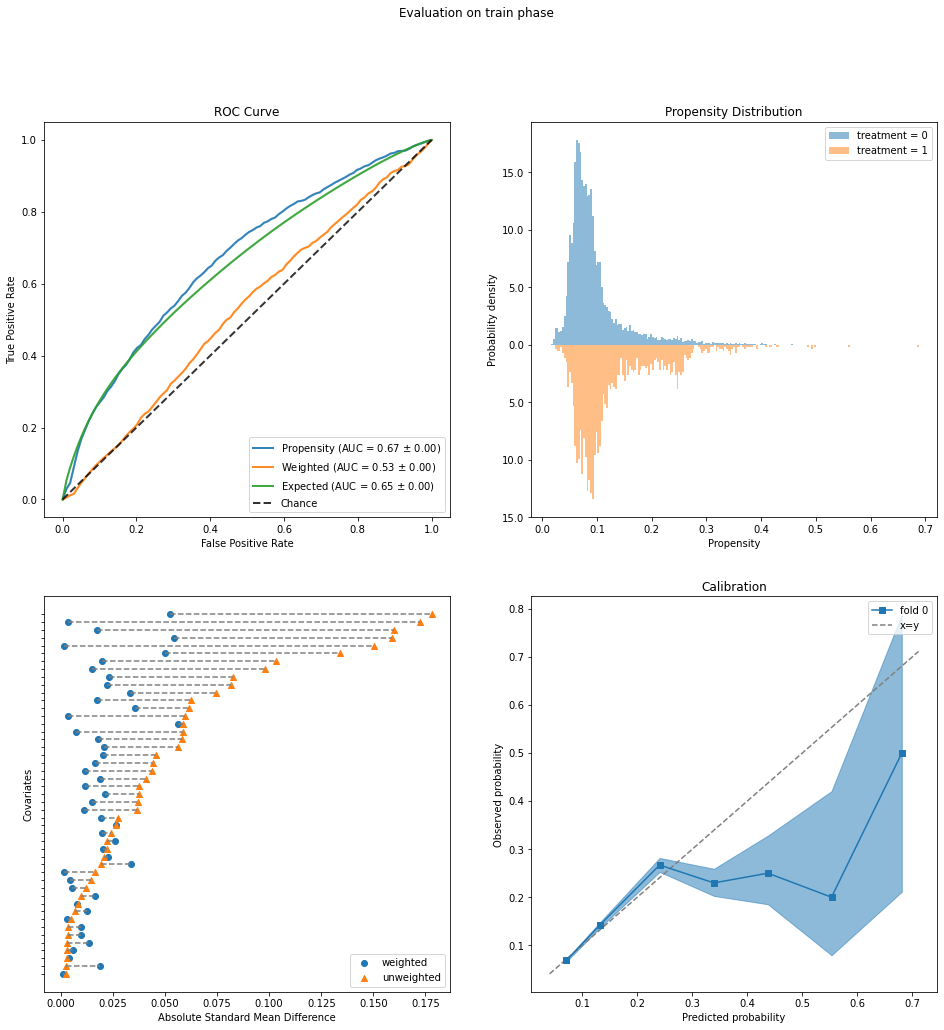

In [25]:
evaluator = PropensityEvaluator(ipw)
eval_results = evaluator.evaluate_simple(X2, a2, y2, plots=["roc_curve", "weight_distribution", "covariate_balance_love", "calibration"])

# IPW Estimate (Refined Cohort)

In [35]:
outcomes2 = ipw.estimate_population_outcome(X2, a2, y2)
ipw.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

diff     0.058681
ratio    1.381831
dtype: float64

# Standardization

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from causallib.estimation import Standardization

#gb = LinearRegression()
gb = GradientBoostingClassifier()
std = Standardization(gb, predict_proba=True)
std.fit(X2, a2, y2)

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Standardization(encode_treatment=False, predict_proba=True,
                learner=GradientBoostingClassifier())

In [37]:
outcomes3 = std.estimate_population_outcome(X2, a2).xs(1, level='y')
std.estimate_effect(outcomes3[0], outcomes3[1], agg='individual', effect_types=['diff','ratio'])

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


diff     0.060398
ratio    1.396935
dtype: float64

In [44]:
print(std.estimate_population_outcome(X2, a2))
print(std.estimate_population_outcome(X2, a2).xs(1, level='y'))

a  y
0  0    0.787440
   1    0.212560
1  0    0.847838
   1    0.152162
dtype: float64
a
0    0.212560
1    0.152162
dtype: float64


/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be 

In [64]:
ind_outcomes = std.estimate_individual_outcome(X2, a2).to_dict(orient="records")

/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/graceguo/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [65]:
I_treatment = []
I_control = []

for i in ind_outcomes:
    i_treatment = i[(1, 1)]
    i_control = i[(0, 1)]
    
    I_treatment.append(i_treatment)
    I_control.append(i_control)

In [66]:
ITE = std.estimate_effect(pd.DataFrame(I_treatment), pd.DataFrame(I_control), agg='individual', effect_types=['ratio'])

In [67]:
ITE.to_json("../public/individual_treatment_effect.json", orient="records")